In [165]:
import numpy as np
import pandas as pd 
import yfinance as yf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, f1_score, balanced_accuracy_score
import optuna
from typing import List

def load_dataset(code: str, start_date: str, end_date: str, horizon: int, object:str, lags: List[int]):
    df = yf.download(code, start=start_date, end=end_date, auto_adjust=False)
    df["Return"] = df["Close"].pct_change()
    df.dropna(inplace=True)

    for lag in lags:
        df[f"MA_shift_{lag}"] = df["Close"].rolling(lag).mean()

    for lag in [5, 10]:
        df[f"Momentum_shift_{lag}"] = df["Close"]/df["Close"].shift(lag) - 1
    
    for lag in [5, 10, 20]:
        df[f"Volatility_shift_{lag}"] = df["Return"].rolling(lag).std()
    
    df["Volume_change"] = df["Volume"].pct_change()

    object: str

    if object.lower() == "regression":
        df["Target"] = df["Return"].shift(-horizon)
    elif object.lower() == "classification":
        df["Target"] = (df["Return"].shift(-horizon) > 0).astype(int)
    else:
        raise KeyError("The key is not valid. Available: ['regression', 'classification']")

    return df.dropna()

In [147]:
df = load_dataset('AAPL', "2015-01-01", "2024-01-01", 1, object='classification',lags=[1, 5, 10, 20])

[*********************100%***********************]  1 of 1 completed


In [148]:
df

Price,Adj Close,Close,High,Low,Open,Volume,Return,MA_shift_1,MA_shift_5,MA_shift_10,MA_shift_20,Momentum_shift_5,Momentum_shift_10,Volatility_shift_5,Volatility_shift_10,Volatility_shift_20,Volume_change,Target
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,
2015-02-02,26.324778,29.657499,29.792500,29.020000,29.512501,250956400,0.012547,29.657499,28.957000,28.397250,27.776625,0.048895,0.119257,0.036233,0.025471,0.023813,-0.250836,1
2015-02-03,26.329222,29.662500,29.772499,29.402500,29.625000,207662800,0.000169,29.662500,29.432500,28.645500,27.931625,0.087136,0.091336,0.027687,0.025176,0.022587,-0.172514,1
2015-02-04,26.531149,29.889999,30.127501,29.577499,29.625000,280598800,0.007670,29.889999,29.645000,28.895750,28.097875,0.036857,0.091374,0.016790,0.025176,0.022551,0.351223,1
2015-02-05,26.720524,29.985001,30.057501,29.812500,30.004999,168984800,0.003178,29.985001,29.697000,29.084250,28.250250,0.008747,0.067082,0.010303,0.024494,0.022482,-0.397771,0
2015-02-06,26.495510,29.732500,30.062500,29.612499,30.004999,174826400,-0.008421,29.732500,29.785500,29.233000,28.338250,0.015108,0.052664,0.007928,0.024966,0.021292,0.034569,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,191.974686,193.600006,195.410004,192.970001,195.179993,37149600,-0.005547,193.600006,195.188000,195.747002,193.668501,-0.020094,-0.010781,0.006438,0.009145,0.009071,-0.200783,0
2023-12-26,191.429291,193.050003,193.889999,192.830002,193.610001,28919300,-0.002841,193.050003,194.620001,195.734003,193.831501,-0.014498,-0.000673,0.005934,0.008196,0.009103,-0.221545,1


In [8]:
tscv = TimeSeriesSplit()

r2_list = []
mse_list = []
mae_list = []

for train_idx, test_idx in tscv.split(df):
    train_df = df[train_idx]
    test_df = df[test_idx]


    X_train = train_df[features]
    X_test = test_df[features]

    y_train = train_df[target]
    y_test = test_df[target]

    model = RandomForestRegre()
    fit, y_pred, fit_optuna, y_pred_optuna, best_model = rf_optimizer(model, )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2_list.append(r2_score(y_test, y_pred))
    mse_list.append(mean_squared_error(y_test, y_pred))
    mae_list.append(mean_absolute_error(y_test, y_pred))


Date
2015-01-02    0
2015-01-05    1
2015-01-06    1
2015-01-07    1
2015-01-08    1
             ..
2023-12-22    0
2023-12-26    1
2023-12-27    1
2023-12-28    0
2023-12-29    0
Name: target, Length: 2264, dtype: int64

In [159]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimator", 100, 2000)
    max_depth = trial.suggest_int("max_depth", 5, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 32)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 32)

    model = RandomForestClassifier(criterion='gini',
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    score = balanced_accuracy_score(y_true=y_test, y_pred=y_pred)

    return score

In [160]:
def rf_optimizer(model, X_train, X_test, y_train, num_trials):
    fit = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner())
    study.optimize(objective, num_trials)

    trial = study.best_trial

    print(f"Best trial: {trial.number}")
    print("Value: {:.4f}".format(trial.value))
    print("Params: ")
    for key, value in trial.params.items():
        print(" {}: {}".format(key, value))
    best_params = study.best_params
    best_n_estimators = best_params['n_estimator']
    best_max_depth = best_params['max_depth']
    best_min_samples_leaf = best_params['min_samples_leaf']
    best_min_samples_split = best_params['min_samples_split']

    best_model = RandomForestClassifier(criterion='gini',
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        min_samples_leaf=best_min_samples_leaf,
        min_samples_split=best_min_samples_split
    )
    
    fit_optuna = best_model.fit(X_train, y_train)
    y_pred_optuna = best_model.predict(X_test)

    return fit, y_pred, fit_optuna, y_pred_optuna, best_model

In [161]:
tscv = TimeSeriesSplit(n_splits=10)

r2_list = []
mse_list = []
mae_list = []
balanced_accuracy_list = []

for train_idx, test_idx in tscv.split(df):
    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    X_train = train_df.drop(columns=["Target"])
    X_test = test_df.drop(columns=["Target"])

    y_train = train_df["Target"]
    y_test = test_df["Target"]

    model = RandomForestClassifier(criterion='gini')
    fit, y_pred, fit_optuna, y_pred_optuna, best_model = rf_optimizer(model, X_train, X_test, y_train, 20)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    balanced_accuracy_list.append(balanced_accuracy_score(y_test, y_pred_optuna))
    r2_list.append(r2_score(y_true=y_test, y_pred=y_pred_optuna))
    mse_list.append(mean_squared_error(y_test, y_pred_optuna))
    mae_list.append(mean_absolute_error(y_test, y_pred_optuna))

[I 2025-08-28 12:40:16,142] A new study created in memory with name: no-name-0f429d1d-fdb4-4e11-9e2c-f658ad7f3727
[I 2025-08-28 12:40:16,372] Trial 0 finished with value: 0.5343137254901961 and parameters: {'n_estimator': 418, 'max_depth': 9, 'min_samples_leaf': 8, 'min_samples_split': 8}. Best is trial 0 with value: 0.5343137254901961.
[I 2025-08-28 12:40:17,065] Trial 1 finished with value: 0.5294117647058824 and parameters: {'n_estimator': 1423, 'max_depth': 8, 'min_samples_leaf': 14, 'min_samples_split': 23}. Best is trial 0 with value: 0.5343137254901961.
[I 2025-08-28 12:40:17,273] Trial 2 finished with value: 0.5441176470588235 and parameters: {'n_estimator': 457, 'max_depth': 5, 'min_samples_leaf': 16, 'min_samples_split': 14}. Best is trial 2 with value: 0.5441176470588235.
[I 2025-08-28 12:40:17,944] Trial 3 finished with value: 0.5 and parameters: {'n_estimator': 1625, 'max_depth': 18, 'min_samples_leaf': 31, 'min_samples_split': 9}. Best is trial 2 with value: 0.54411764705

Best trial: 6
Value: 0.5588
Params: 
 n_estimator: 659
 max_depth: 16
 min_samples_leaf: 18
 min_samples_split: 21


[I 2025-08-28 12:40:28,878] A new study created in memory with name: no-name-af9fdbd0-b25a-473f-a622-3ad6569c260d
[I 2025-08-28 12:40:30,003] Trial 0 finished with value: 0.5089941972920696 and parameters: {'n_estimator': 1930, 'max_depth': 19, 'min_samples_leaf': 25, 'min_samples_split': 28}. Best is trial 0 with value: 0.5089941972920696.
[I 2025-08-28 12:40:31,317] Trial 1 finished with value: 0.5279497098646034 and parameters: {'n_estimator': 1750, 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 16}. Best is trial 1 with value: 0.5279497098646034.
[I 2025-08-28 12:40:31,643] Trial 2 finished with value: 0.5188588007736944 and parameters: {'n_estimator': 481, 'max_depth': 13, 'min_samples_leaf': 10, 'min_samples_split': 32}. Best is trial 1 with value: 0.5279497098646034.
[I 2025-08-28 12:40:32,148] Trial 3 finished with value: 0.5089941972920696 and parameters: {'n_estimator': 708, 'max_depth': 9, 'min_samples_leaf': 9, 'min_samples_split': 24}. Best is trial 1 with val

Best trial: 1
Value: 0.5279
Params: 
 n_estimator: 1750
 max_depth: 7
 min_samples_leaf: 3
 min_samples_split: 16


[I 2025-08-28 12:40:44,672] A new study created in memory with name: no-name-ecfb3f4b-7fcb-48f0-bff1-0b404d32e58e
[I 2025-08-28 12:40:45,919] Trial 0 finished with value: 0.47056556508334135 and parameters: {'n_estimator': 1382, 'max_depth': 17, 'min_samples_leaf': 18, 'min_samples_split': 16}. Best is trial 0 with value: 0.47056556508334135.
[I 2025-08-28 12:40:47,108] Trial 1 finished with value: 0.4720107910203295 and parameters: {'n_estimator': 1292, 'max_depth': 15, 'min_samples_leaf': 13, 'min_samples_split': 5}. Best is trial 1 with value: 0.4720107910203295.
[I 2025-08-28 12:40:48,309] Trial 2 finished with value: 0.4715290490413334 and parameters: {'n_estimator': 1452, 'max_depth': 20, 'min_samples_leaf': 19, 'min_samples_split': 9}. Best is trial 1 with value: 0.4720107910203295.
[I 2025-08-28 12:40:49,320] Trial 3 finished with value: 0.48776375373350034 and parameters: {'n_estimator': 1172, 'max_depth': 6, 'min_samples_leaf': 9, 'min_samples_split': 30}. Best is trial 3 wit

Best trial: 14
Value: 0.5256
Params: 
 n_estimator: 730
 max_depth: 10
 min_samples_leaf: 3
 min_samples_split: 22


[I 2025-08-28 12:41:06,267] A new study created in memory with name: no-name-3c831a7d-74b7-4103-818a-beae2bbc20a4
[I 2025-08-28 12:41:07,158] Trial 0 finished with value: 0.5171179883945841 and parameters: {'n_estimator': 835, 'max_depth': 20, 'min_samples_leaf': 22, 'min_samples_split': 17}. Best is trial 0 with value: 0.5171179883945841.
[I 2025-08-28 12:41:07,270] Trial 1 finished with value: 0.5216634429400386 and parameters: {'n_estimator': 119, 'max_depth': 5, 'min_samples_leaf': 25, 'min_samples_split': 22}. Best is trial 1 with value: 0.5216634429400386.
[I 2025-08-28 12:41:08,542] Trial 2 finished with value: 0.5171179883945841 and parameters: {'n_estimator': 789, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 7}. Best is trial 1 with value: 0.5216634429400386.
[I 2025-08-28 12:41:10,902] Trial 3 finished with value: 0.5216634429400386 and parameters: {'n_estimator': 1551, 'max_depth': 13, 'min_samples_leaf': 4, 'min_samples_split': 11}. Best is trial 1 with valu

Best trial: 9
Value: 0.5254
Params: 
 n_estimator: 600
 max_depth: 20
 min_samples_leaf: 18
 min_samples_split: 29


[I 2025-08-28 12:41:35,699] A new study created in memory with name: no-name-25e0e100-a56f-4fb2-b3e0-caf62a33f622
[I 2025-08-28 12:41:36,429] Trial 0 finished with value: 0.4774303859306302 and parameters: {'n_estimator': 529, 'max_depth': 6, 'min_samples_leaf': 11, 'min_samples_split': 4}. Best is trial 0 with value: 0.4774303859306302.
[I 2025-08-28 12:41:38,652] Trial 1 finished with value: 0.45823155837811436 and parameters: {'n_estimator': 1270, 'max_depth': 15, 'min_samples_leaf': 9, 'min_samples_split': 10}. Best is trial 0 with value: 0.4774303859306302.
[I 2025-08-28 12:41:38,883] Trial 2 finished with value: 0.4714704445530044 and parameters: {'n_estimator': 100, 'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 16}. Best is trial 0 with value: 0.4774303859306302.
[I 2025-08-28 12:41:40,345] Trial 3 finished with value: 0.46453346360527603 and parameters: {'n_estimator': 1039, 'max_depth': 12, 'min_samples_leaf': 23, 'min_samples_split': 3}. Best is trial 0 with va

Best trial: 13
Value: 0.5019
Params: 
 n_estimator: 721
 max_depth: 19
 min_samples_leaf: 3
 min_samples_split: 16


[I 2025-08-28 12:42:09,943] A new study created in memory with name: no-name-858ac650-7e97-43e6-8fa4-58b120ddc838
[I 2025-08-28 12:42:12,792] Trial 0 finished with value: 0.5350705329153606 and parameters: {'n_estimator': 1958, 'max_depth': 7, 'min_samples_leaf': 27, 'min_samples_split': 6}. Best is trial 0 with value: 0.5350705329153606.
[I 2025-08-28 12:42:15,456] Trial 1 finished with value: 0.5321316614420063 and parameters: {'n_estimator': 1614, 'max_depth': 7, 'min_samples_leaf': 19, 'min_samples_split': 18}. Best is trial 0 with value: 0.5350705329153606.
[I 2025-08-28 12:42:18,209] Trial 2 finished with value: 0.49216300940438873 and parameters: {'n_estimator': 1554, 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 18}. Best is trial 0 with value: 0.5350705329153606.
[I 2025-08-28 12:42:20,799] Trial 3 finished with value: 0.5266457680250783 and parameters: {'n_estimator': 1432, 'max_depth': 20, 'min_samples_leaf': 20, 'min_samples_split': 8}. Best is trial 0 with va

Best trial: 17
Value: 0.5408
Params: 
 n_estimator: 849
 max_depth: 16
 min_samples_leaf: 29
 min_samples_split: 24


[I 2025-08-28 12:42:52,190] A new study created in memory with name: no-name-9de4be89-f982-446f-ad8b-e509d6046cbf
[I 2025-08-28 12:42:54,665] Trial 0 finished with value: 0.5059615384615385 and parameters: {'n_estimator': 1349, 'max_depth': 6, 'min_samples_leaf': 13, 'min_samples_split': 15}. Best is trial 0 with value: 0.5059615384615385.
[I 2025-08-28 12:42:57,557] Trial 1 finished with value: 0.5376923076923077 and parameters: {'n_estimator': 1226, 'max_depth': 8, 'min_samples_leaf': 7, 'min_samples_split': 28}. Best is trial 1 with value: 0.5376923076923077.
[I 2025-08-28 12:42:59,242] Trial 2 finished with value: 0.5296153846153846 and parameters: {'n_estimator': 659, 'max_depth': 15, 'min_samples_leaf': 6, 'min_samples_split': 30}. Best is trial 1 with value: 0.5376923076923077.
[I 2025-08-28 12:42:59,565] Trial 3 finished with value: 0.5053846153846153 and parameters: {'n_estimator': 209, 'max_depth': 5, 'min_samples_leaf': 18, 'min_samples_split': 23}. Best is trial 1 with valu

Best trial: 16
Value: 0.5425
Params: 
 n_estimator: 660
 max_depth: 15
 min_samples_leaf: 3
 min_samples_split: 29


[I 2025-08-28 12:43:40,773] A new study created in memory with name: no-name-980317ca-dcce-4ae8-8c4e-91180887f7f1
[I 2025-08-28 12:43:43,969] Trial 0 finished with value: 0.5084615384615384 and parameters: {'n_estimator': 1605, 'max_depth': 6, 'min_samples_leaf': 19, 'min_samples_split': 12}. Best is trial 0 with value: 0.5084615384615384.
[I 2025-08-28 12:43:44,480] Trial 1 finished with value: 0.5076923076923077 and parameters: {'n_estimator': 227, 'max_depth': 8, 'min_samples_leaf': 19, 'min_samples_split': 27}. Best is trial 0 with value: 0.5084615384615384.
[I 2025-08-28 12:43:47,781] Trial 2 finished with value: 0.5026923076923077 and parameters: {'n_estimator': 1265, 'max_depth': 10, 'min_samples_leaf': 13, 'min_samples_split': 4}. Best is trial 0 with value: 0.5084615384615384.
[I 2025-08-28 12:43:51,825] Trial 3 finished with value: 0.5140384615384616 and parameters: {'n_estimator': 1736, 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 31}. Best is trial 3 with val

Best trial: 8
Value: 0.5275
Params: 
 n_estimator: 903
 max_depth: 15
 min_samples_leaf: 2
 min_samples_split: 22


[I 2025-08-28 12:44:28,265] A new study created in memory with name: no-name-21ca2d38-8f8a-421b-92b9-904cf6ba8ad1
[I 2025-08-28 12:44:29,914] Trial 0 finished with value: 0.5281168893588388 and parameters: {'n_estimator': 591, 'max_depth': 19, 'min_samples_leaf': 25, 'min_samples_split': 25}. Best is trial 0 with value: 0.5281168893588388.
[I 2025-08-28 12:44:33,234] Trial 1 finished with value: 0.5409497260405652 and parameters: {'n_estimator': 1635, 'max_depth': 5, 'min_samples_leaf': 16, 'min_samples_split': 31}. Best is trial 1 with value: 0.5409497260405652.
[I 2025-08-28 12:44:38,161] Trial 2 finished with value: 0.5031721618763818 and parameters: {'n_estimator': 1855, 'max_depth': 18, 'min_samples_leaf': 30, 'min_samples_split': 2}. Best is trial 1 with value: 0.5409497260405652.
[I 2025-08-28 12:44:40,752] Trial 3 finished with value: 0.4992790541190041 and parameters: {'n_estimator': 732, 'max_depth': 13, 'min_samples_leaf': 10, 'min_samples_split': 23}. Best is trial 1 with v

Best trial: 1
Value: 0.5409
Params: 
 n_estimator: 1635
 max_depth: 5
 min_samples_leaf: 16
 min_samples_split: 31


[I 2025-08-28 12:45:37,525] A new study created in memory with name: no-name-6e64556d-301c-4adf-8bbb-a593db6558a9
[I 2025-08-28 12:45:42,052] Trial 0 finished with value: 0.49026445800639346 and parameters: {'n_estimator': 1410, 'max_depth': 10, 'min_samples_leaf': 21, 'min_samples_split': 22}. Best is trial 0 with value: 0.49026445800639346.
[I 2025-08-28 12:45:43,209] Trial 1 finished with value: 0.48575995350188894 and parameters: {'n_estimator': 291, 'max_depth': 15, 'min_samples_leaf': 18, 'min_samples_split': 6}. Best is trial 0 with value: 0.49026445800639346.
[I 2025-08-28 12:45:48,323] Trial 2 finished with value: 0.51453065969195 and parameters: {'n_estimator': 1336, 'max_depth': 11, 'min_samples_leaf': 9, 'min_samples_split': 7}. Best is trial 2 with value: 0.51453065969195.
[I 2025-08-28 12:45:51,704] Trial 3 finished with value: 0.507265329845975 and parameters: {'n_estimator': 1603, 'max_depth': 5, 'min_samples_leaf': 29, 'min_samples_split': 9}. Best is trial 2 with valu

Best trial: 2
Value: 0.5145
Params: 
 n_estimator: 1336
 max_depth: 11
 min_samples_leaf: 9
 min_samples_split: 7


In [163]:
balanced_accuracy_list

[]

In [162]:
df["Target"].value_counts(normalize=True)

Target
1    0.526292
0    0.473708
Name: proportion, dtype: float64

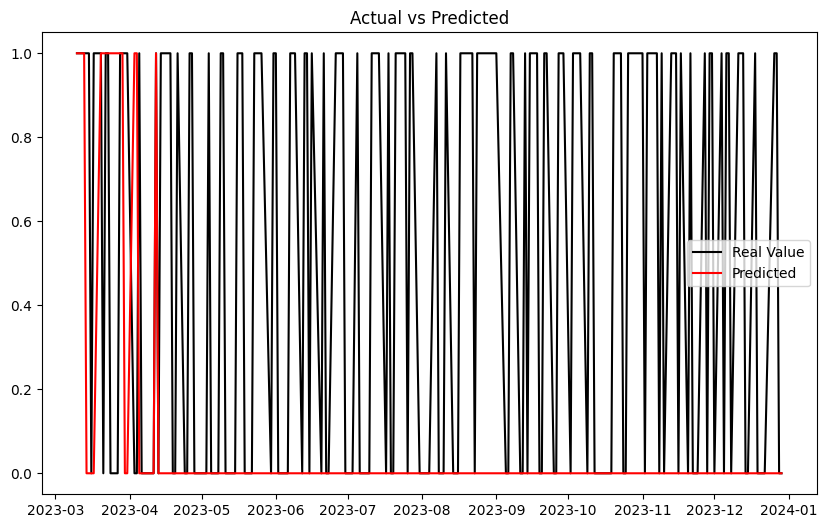

In [155]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, color='k', label='Real Value')
plt.plot(y_test.index, y_pred_optuna, color='r', label='Predicted')
plt.title("Actual vs Predicted")
plt.legend()
plt.show()

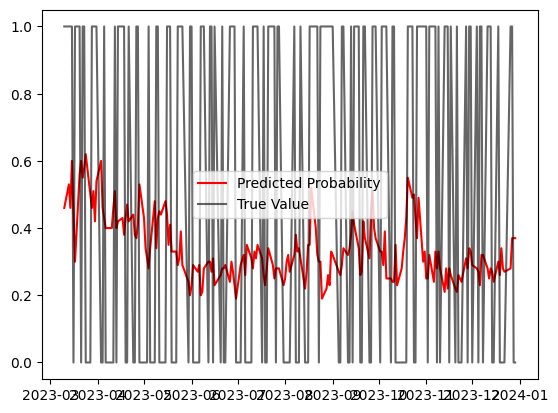

In [164]:
y_proba = model.predict_proba(X_test)[:,1]
plt.plot(y_test.index, y_proba, label = "Predicted Probability", color="r")
plt.plot(y_test.index, y_test.values, label="True Value", color="k", alpha=0.6)
plt.legend()

In [2]:
def evaluate_classification(y_true, y_pred, y_proba=None):

    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy_score": balanced_accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro")
    }

    majority_class = np.bincount(y_true).argmax()
    y_majority = np.full_like(y_true, majority_class)
    metrics["baseline_majority_acc"] = accuracy_score(y_true, y_majority)
    metrics["baseline_majority_bal_acc"] = balanced_accuracy_score(y_true, y_majority)

    y_persistence = np.roll(y_true, 1)
    y_persistence[0] = 0
    metrics["baseline_persistence_acc"] = accuracy_score(y_true, y_persistence)
    metrics["baseline_persistence_bal_acc"] = balanced_accuracy_score(y_true, y_persistence)

    return metrics

In [ ]:
metrics = evaluate_classification(y_test, y_pred_optuna, y_proba)

for k,v in metrics.items():
    print(f"{k}: {v:.3f}")